## Pooling Layer

Pooling is a technique used in the CNN model for down-sampling the feature coming from the preveious layer and produce the new summarised feature maps. The goal of pooling is to reduce computationa complexity of the model and make it robust.
* **Max Pooling**: selects the maximum valu from each set of overlapping filters and passes this maximum valut to the next layer

* **Average Pooling**: computes the average valu of each set of overlapping filters and passes this average value to the next layer.  

<img src="./rsc/MaxAveragePooling.gif" widht="600" height="800">

Image from [introduction to pooling layers in CNN](https://pub.towardsai.net/introduction-to-pooling-layers-in-cnn-dafe61eabe34) by Rafay Qayyum

### Dimentional reduction
1. Convolutional layer with stride = 2<br>
   `Conv(f=3,s=2,p=1)`-> `ReLU`
   
2. Pooling layer with strid =2<br>
   `Conv(f=3,s=1,p=1)`-> `ReLU`->`Pooling(f=2,s=2)`
   
Both methods reduce the output size by half  

In [124]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import utils

In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),std=(0.5,))
])
train_dataset = torchvision.datasets.MNIST(root='./data/mnist_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST(root='./data/mnist_data', train=False, download=True, transform=transform)

In [22]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True, num_workers=4)

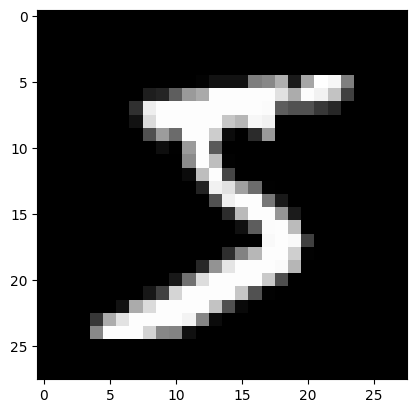

In [55]:
im ,label = train_dataset[0]
im = im[0,:,:]
plt.imshow(im, cmap='gray')

In [74]:
def max_pooling(X, kernel_size=2, stride=2):
    
    X_h, X_w = X.shape
    
    height = X_w - kernel_size +1
    width = X_w - kernel_size +1
    
    output_data = []
    for h in range(0,height,stride):
        row = []
        for w in range(0,width,stride):
            row.append(im[h:h+kernel_size,w:w+kernel_size].max().item())
    
        output_data.append(row)

    return torch.tensor(output_data)
            

image size: orignal torch.Size([28, 28]), Max pooling torch.Size([14, 14])


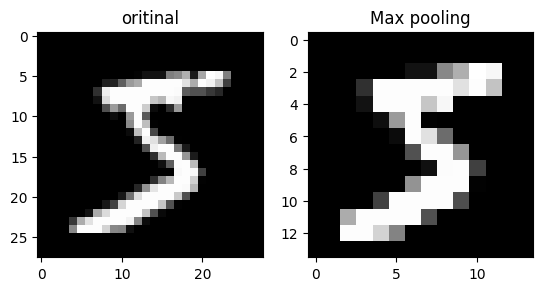

In [77]:
max_im = max_pooling(im)
fig= plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(im, cmap='gray')
plt.title('oritinal')
fig.add_subplot(1,2,2)
plt.imshow(max_im, cmap='gray')
plt.title('Max pooling')
print(f'image size: orignal {im.shape}, Max pooling {max_im.shape}')

#### Convolutional layer + Maxpooling
Max Pooling is usually used after a convolutional layer <br>
`Conv(f=3,s=1,p=1)`-> `ReLU`->`Pooling(f=2,s=2)`

In [88]:
def apply_filter(im, filter):
    im_h,im_w = im.shape
    f_h,f_w = filter.shape
    
    height = im_h - f_h + 1
    width = im_w - f_w + 1
    
    output_data= []
    
    for h in range(height):
        row = []
        for w in range(width):
            row.append((im[h:h+f_h,w:w+f_w] * filter).sum().item())
        output_data.append(row)
    
    return torch.tensor(output_data)

def relu(X):
    return torch.clamp(X, min=0)

In [89]:
top_edge_filter = torch.tensor([[1,1,1],
                               [0,0,0],
                               [-1,-1,-1]])
conv_out = apply_filter(im, top_edge_filter)
relu_out = relu(conv_out)
max_out = max_pooling(relu_out)

image size: Orignal torch.Size([28, 28]), Conv. torch.Size([26, 26]) Relu torch.Size([26, 26]) Max pooling torch.Size([13, 13])


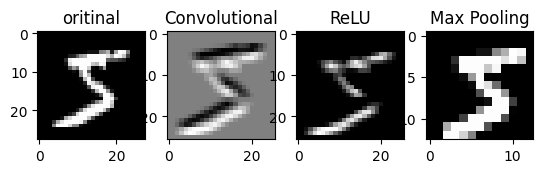

In [90]:
fig= plt.figure()
fig.add_subplot(1,4,1)
plt.imshow(im, cmap='gray')
plt.title('oritinal')
fig.add_subplot(1,4,2)
plt.imshow(conv_out, cmap='gray')
plt.title('Convolutional')
fig.add_subplot(1,4,3)
plt.imshow(relu_out, cmap='gray')
plt.title('ReLU')
fig.add_subplot(1,4,4)
plt.imshow(max_out, cmap='gray')
plt.title('Max Pooling')
print(f'image size: Orignal {im.shape}, Conv. {conv_out.shape} Relu {relu_out.shape} Max pooling {max_out.shape}')

### Global Average Pooling (GAP)

>**Global average pooling** is a pooling operation designed to replace fully connected layers in classical CNNs. The idea is to generate one feature map for each corresponding category of the classification task in the last mlpconv layer. Instead of adding fully connected layers on top of the feature maps, we take the average of each feature map, and the resulting vector is fed directly into the softmax layer.

>One advantage of global average pooling over the fully connected layers is that it is more native to the convolution structure by enforcing correspondences between feature maps and categories. Thus the feature maps can be easily interpreted as categories confidence maps. Another advantage is that there is no parameter to optimize in the global average pooling thus overfitting is avoided at this layer. Furthermore, global average pooling sums out the spatial information, thus it is more robust to spatial translations of the input.

Source : [Network in Network](https://arxiv.org/abs/1312.4400v3)

In [100]:
class GlobalAveragePooling(nn.Module):
    def forward(self, X):
        return torch.mean(X, dim=(2,3), keepdim=True)

In [101]:
X=torch.randn(128,3,4,4)

In [102]:
gap_layer=GlobalAveragePooling()
gap_out = gap_layer(X)
gap_out.shape

torch.Size([128, 3, 1, 1])

### AdaptiveAvgPool2d

There is no GAP module in pytorch but, `AdaptiveAvgPool2d` does work similarly. 

Applies a 2D adaptive average pooling over an input signal composed of several input planes.

The output is of size H x W, for any input size. The number of output features is equal to the number of input planes.

**Parameters**:

**output_size** (Union[int, None, Tuple[Optional[int], Optional[int]]]) – the target output size of the image of the form H x W. Can be a tuple (H, W) or a single H for a square image H x H. H and W can be either a int, or None which means the size will be the same as that of the input.

**Shape**

* Input: $(N,C,H_{in},W_{in})$ or $(C,H_{in},W_{in})$
* Output: $(N,C,S_0,S_1)$ or $(C,S_0,S_1)$, where $S$=output_size.

Examples:
```python
# target output size of 5x7
m = nn.AdaptiveAvgPool2d((5, 7))
input = torch.randn(1, 64, 8, 9)
output = m(input)
# target output size of 7x7 (square)
m = nn.AdaptiveAvgPool2d(7)
input = torch.randn(1, 64, 10, 9)
output = m(input)
```

Source: [torch.nn.AdaptiveAvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html)

In [107]:
gap_layer = nn.AdaptiveAvgPool2d(1)
gap_layer(X).shape, X.shape

(torch.Size([128, 3, 1, 1]), torch.Size([128, 3, 4, 4]))

### Integrate GAP layer with convolution layer

In [136]:
conv_model=nn.Sequential(
        # 1x28x28
        nn.Conv2d(in_channels=1,out_channels=4, kernel_size=3, stride=2,padding=1), 
        nn.ReLU(),
        # 4x14x14
        nn.Conv2d(in_channels=4,out_channels=8, kernel_size=3, stride=2,padding=1), 
        nn.ReLU(),
        # 8x7x7
        nn.Conv2d(in_channels=8,out_channels=16, kernel_size=3, stride=2,padding=1), 
        nn.ReLU(),
        # 16x4x4
        nn.Conv2d(in_channels=16,out_channels=32, kernel_size=3, stride=2,padding=1), 
        nn.ReLU(),
        # 32x2x2

        # gap layer: 32x2x2 -> 32x1x1
        # nn.AdaptiveAvgPool2d(1),
    
        nn.Flatten(),
        nn.Linear(128,10)
        
)

In [137]:
X = torch.randn(128, 1,28,28)
conv_model(X)

tensor([[ 0.0775, -0.0766, -0.0784,  ..., -0.0741, -0.0105, -0.0778],
        [ 0.0899, -0.0738, -0.0652,  ..., -0.0761, -0.0261, -0.0866],
        [ 0.0858, -0.0688, -0.0652,  ..., -0.0689, -0.0285, -0.0927],
        ...,
        [ 0.0899, -0.0694, -0.0766,  ..., -0.0720, -0.0250, -0.1001],
        [ 0.0710, -0.0784, -0.0757,  ..., -0.0812, -0.0119, -0.0788],
        [ 0.0683, -0.0784, -0.0662,  ..., -0.0731, -0.0178, -0.0990]],
       grad_fn=<AddmmBackward0>)

Conv_model only accepts 1x28x28 shape. If you feed a different shape such as 1x64x64, it will return an error

In [139]:
X = torch.randn(128, 1,64,64)
conv_model(X)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x512 and 128x10)

This is because the input shape is different from the input shape which the last linear layer exptects. 

In [150]:
conv_model=nn.Sequential(
        # 1x28x28
        nn.Conv2d(in_channels=1,out_channels=4, kernel_size=3, stride=2,padding=1), 
        nn.ReLU(),
        # 4x14x14
        nn.Conv2d(in_channels=4,out_channels=8, kernel_size=3, stride=2,padding=1), 
        nn.ReLU(),
        # 8x7x7
        nn.Conv2d(in_channels=8,out_channels=16, kernel_size=3, stride=2,padding=1), 
        nn.ReLU(),
        # 16x4x4
        nn.Conv2d(in_channels=16,out_channels=32, kernel_size=3, stride=2,padding=1), 
        nn.ReLU(),
        # 32x2x2

        # gap layer: 32x2x2 -> 32x1x1
        nn.AdaptiveAvgPool2d(1),
    
        nn.Flatten(),
        nn.Linear(32,10)
        
)

In [153]:
X = torch.randn(128,1, 64,64)
conv_model(X).shape

torch.Size([128, 10])

By using a GAP layer, you could feed variable shape. 